# Курсовой проект

# Построение модели классификации

## 1.Обзор обучающего датасета

Подключение библиотек и скриптов

In [272]:
#!pip install xgboost
#!pip install lightgbm
# !pip install catboost

In [335]:
import numpy as np
import pandas as pd

In [336]:
import pickle

In [337]:
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

In [338]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

In [339]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [405]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [412]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.idxmax()
    minor_class_name = target_counts.idxmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

Пути к директориям и файлам

In [418]:
# input
#TRAIN_DATASET_PATH = 'course_project_train.csv'
#TEST_DATASET_PATH = 'course_project_test.csv'

DATASET_PATH = 'course_project_train.csv'

# output
PREP_DATASET_PATH = 'course_project_train_prev.csv'

DATASET_CAT_PATH  = 'course_project_train_cat.csv'

# output
TRAIN_FULL_PATH = 'training_project_train_full.csv'
TRAIN_PART_PATH = 'training_project_train_part_b.csv'
TEST_PART_PATH = 'training_project_test_part.csv'

SCALER_FILE_PATH = 'scaler.pkl'

### Загрузка данных

Описание базового датасета

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [490]:
df_base = pd.read_csv(DATASET_PATH)
#df = pd.read_csv(PREP_DATASET_PATH)

df = pd.read_csv(DATASET_PATH)

df_cat = pd.read_csv(DATASET_CAT_PATH)

df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [342]:
df.shape

(7500, 17)

In [343]:
df.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [400]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

Приведение типов

# ???

In [345]:
for col_name in df.select_dtypes(include='object').columns:
    df[col_name]=df[col_name].astype(str)

In [346]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7500 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

### Выделение целевой переменной и групп признаков

In [398]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME, 'ID'] + BASE_FEATURE_NAMES).tolist()

KeyError: "['ID'] not found in axis"

In [396]:
NEW_FEATURE_NAMES

Index([], dtype='object')

In [399]:
df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

In [397]:
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

### Обзор распределения

In [348]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

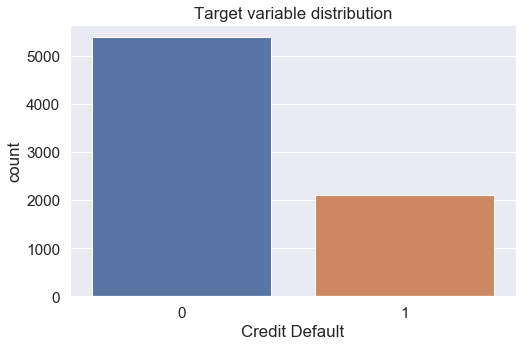

In [349]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

числовые переменные ??

In [350]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


 Номинальные??

In [351]:
for col_name in df.select_dtypes(include='object').columns:
    print(str(col_name)+'   \n'+str(df[col_name].value_counts()))

Home Ownership   
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
Years in current job   
10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
nan           371
8 years       339
9 years       259
Name: Years in current job, dtype: int64
Purpose   
debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
Term   
Short Term    5556
Long Term     1944
Name: Term, dtype: int64


### Обработка пропусков

In [498]:
len(df)-df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Будем считать, что если не было просрочек платежа, то 0

In [501]:
df['Months since last delinquent']=df['Months since last delinquent'].fillna(0)

In [502]:
df

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,0.0,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,0.0,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


In [503]:
df['Credit Score']=df['Credit Score'].fillna(0)

In [504]:
df['Bankruptcies']=df['Bankruptcies'].fillna(0)

Пропишем среднее значение в годовой доход с пропусками

In [505]:
df['Annual Income']=df['Annual Income'].fillna(1366392)

Корреляция с базовыми признаками

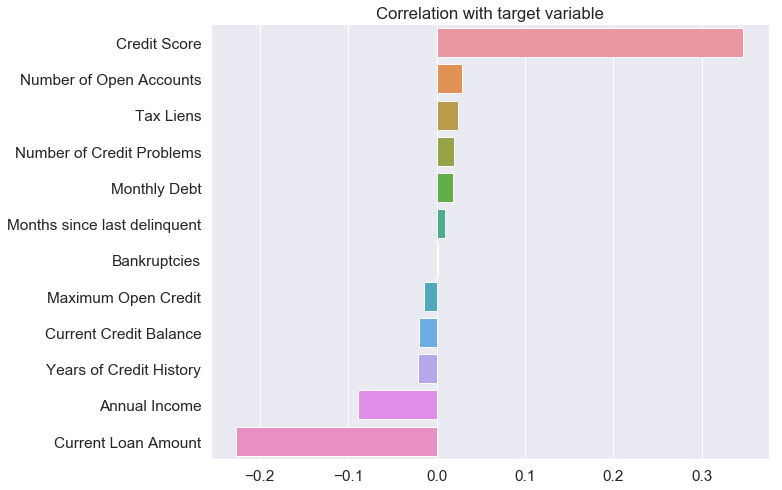

In [358]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Оценка признака с наибольшим влиянием в разрезе целевой переменной

In [359]:
#CORRELATION_FEATURE_NAME = "Current Loan Amount"
CORRELATION_FEATURE_NAME = "Credit Score"
#CORRELATION_FEATURE_NAME = "Bankruptcies"

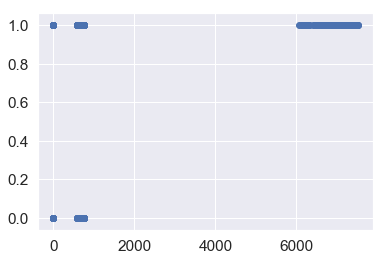

In [360]:
plt.scatter(df[CORRELATION_FEATURE_NAME],df[TARGET_NAME])

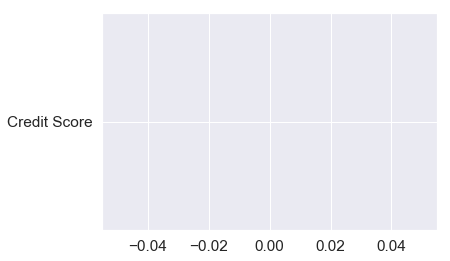

In [361]:
plt.plot(CORRELATION_FEATURE_NAME)

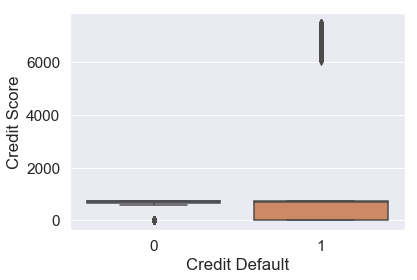

In [362]:
sns.boxplot(x=df[TARGET_NAME],y=df[CORRELATION_FEATURE_NAME])

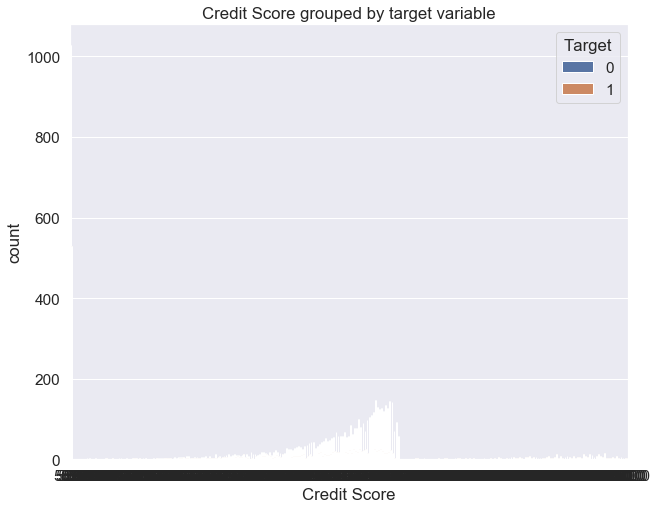

In [506]:
plt.figure(figsize=(10, 8))

sns.countplot(x=CORRELATION_FEATURE_NAME, hue=TARGET_NAME, data=df)
plt.title(CORRELATION_FEATURE_NAME+' grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [507]:
df[CORRELATION_FEATURE_NAME].fillna(0).astype(np.int64)

0        749
1        737
2        742
3        694
4        719
5          0
6        745
7        705
8          0
9          0
10         0
11       737
12       706
13       728
14       748
15       727
16         0
17       644
18       695
19       712
20       697
21       719
22       738
23         0
24         0
25       720
26       742
27       734
28       740
29         0
        ... 
7470       0
7471     718
7472     726
7473     737
7474     720
7475     742
7476     721
7477     750
7478     703
7479     739
7480     747
7481     739
7482       0
7483     658
7484     741
7485     736
7486     750
7487     695
7488     728
7489     742
7490     688
7491     704
7492       0
7493     676
7494       0
7495     697
7496    7410
7497     748
7498       0
7499       0
Name: Credit Score, Length: 7500, dtype: int64

Сформируем выборку и рассчитаем наблюдаемые частоты

In [508]:
cor_and_target_s = df.loc[df[CORRELATION_FEATURE_NAME].fillna(0).astype(np.int64), ['ID', CORRELATION_FEATURE_NAME, TARGET_NAME]].sample(3000)

C:\Users\avsokolov-adm\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [510]:
table = cor_and_target_s.pivot_table(values='ID', index=CORRELATION_FEATURE_NAME, columns=TARGET_NAME, aggfunc='count')
table

Credit Default,0.0,1.0
Credit Score,,
0.0,0.0,0.0
593.0,NaN,0.0
621.0,NaN,0.0
622.0,NaN,0.0
637.0,0.0,NaN
642.0,NaN,0.0
648.0,NaN,0.0
650.0,0.0,NaN
651.0,0.0,NaN


In [511]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

C:\Users\avsokolov-adm\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\contingency.py:243: RuntimeWarning: invalid value encountered in less
  if np.any(observed < 0):
C:\Users\avsokolov-adm\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\avsokolov-adm\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\avsokolov-adm\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


nan

In [512]:
#CORRELATION_FEATURE_NAME = "Current Loan Amount"
CORRELATION_FEATURE_NAME = "Credit Score"
#CORRELATION_FEATURE_NAME = "Bankruptcies"

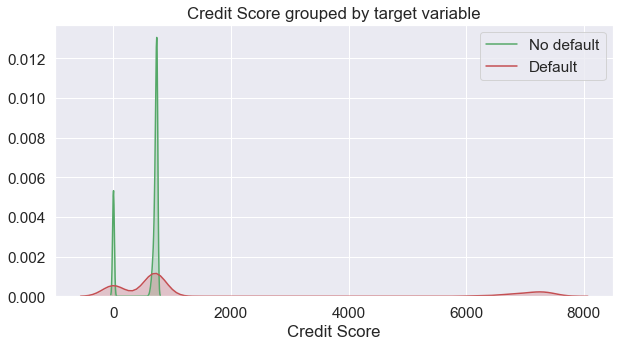

In [513]:
limit_bal_with_target_s = df[[CORRELATION_FEATURE_NAME, TARGET_NAME]].sample(1000)
limit_bal_s = limit_bal_with_target_s[CORRELATION_FEATURE_NAME]
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 0]
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

plt.xlabel(CORRELATION_FEATURE_NAME)
plt.title(CORRELATION_FEATURE_NAME + ' grouped by target variable')
plt.show()

In [514]:
shapiro(limit_bal_s)

(0.3838513493537903, 0.0)

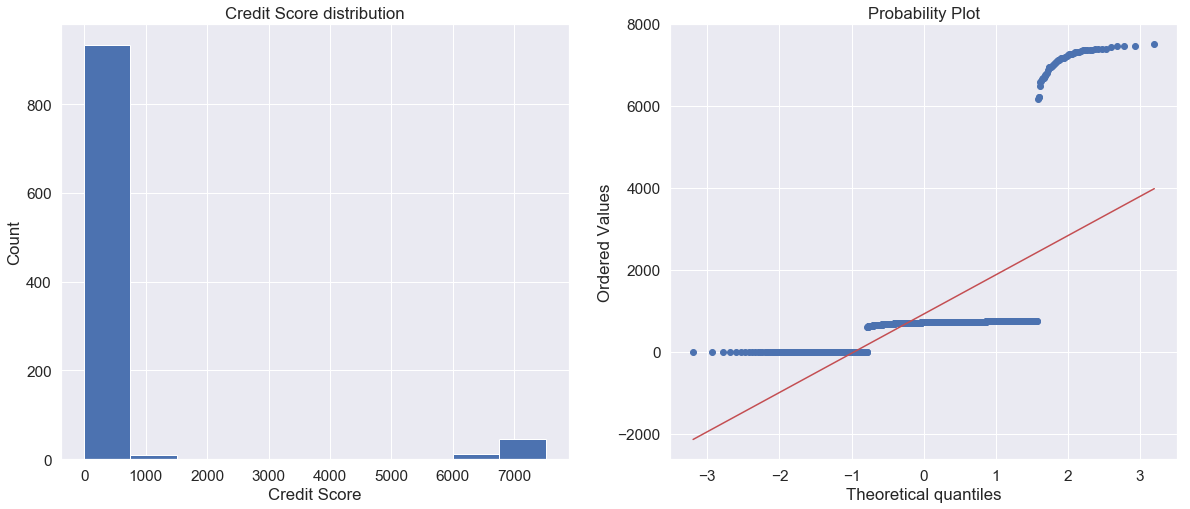

In [515]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel(CORRELATION_FEATURE_NAME)
ax1.set_ylabel('Count')
ax1.set_title(CORRELATION_FEATURE_NAME+' distribution')
limit_bal_s.hist()

plt.subplot(122)
probplot(limit_bal_s, dist='norm', plot=plt)

plt.show()

In [516]:
mannwhitneyu(limit_bal_target_0, limit_bal_target_1)

MannwhitneyuResult(statistic=101201.5, pvalue=0.22088431766012856)

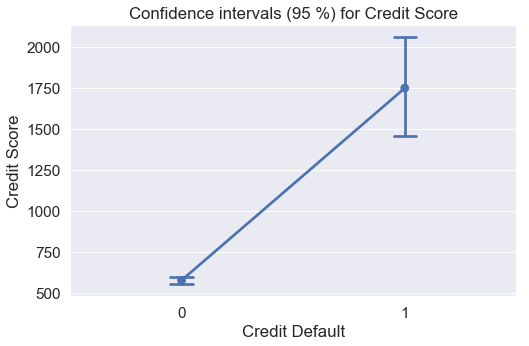

In [517]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y=CORRELATION_FEATURE_NAME, data=limit_bal_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for ' + CORRELATION_FEATURE_NAME)
plt.show()

## 2.Обработка выбросов

## 3.Обработка пропусков

## 4.Анализ данных

### Анализ признакового пространства

Матрица корреляций

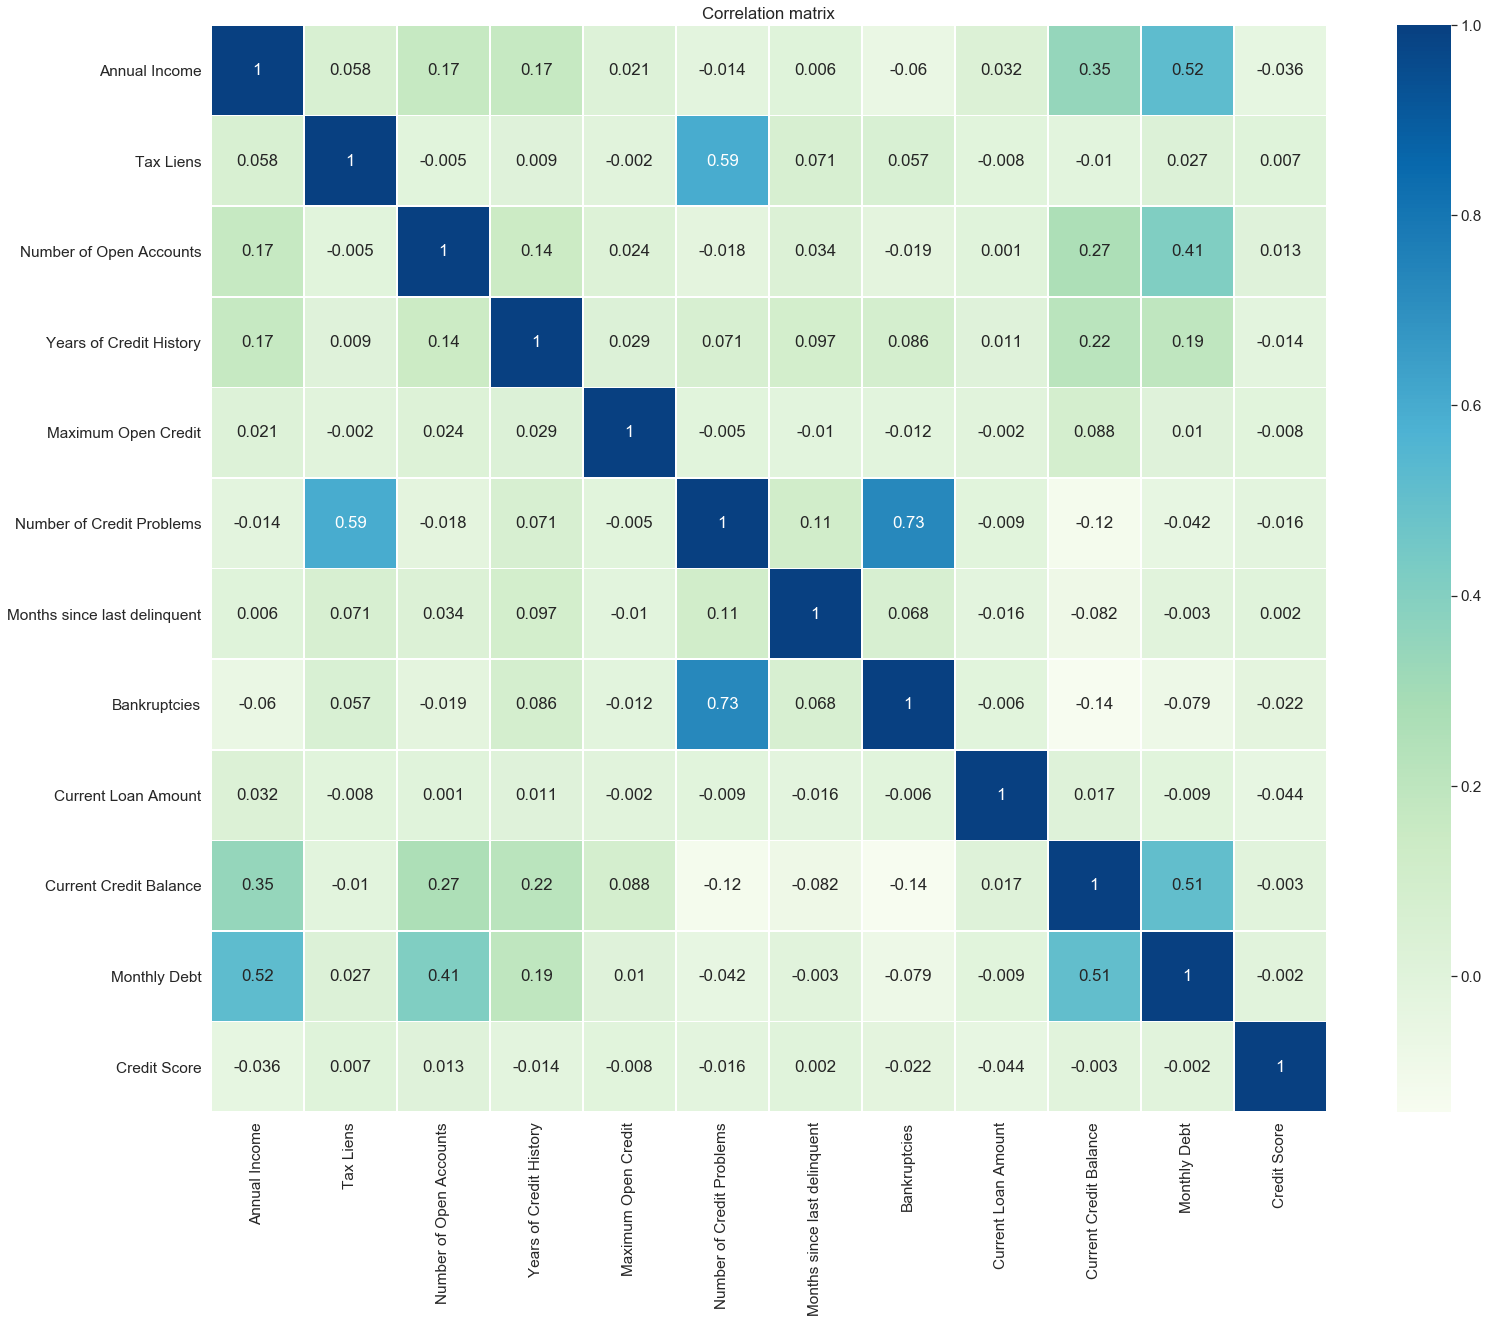

In [518]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Выделение целевой переменной и групп признаков

In [524]:
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

In [525]:
NUM_FEATURE_NAMES = df_base.select_dtypes(include=['float64']).columns

????

In [526]:
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [527]:
NEW_FEATURE_NAMES

[]

In [528]:
NUM_FEATURE_NAMES

Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score'],
      dtype='object')

In [529]:
CAT_FEATURE_NAMES = df_base.select_dtypes(include=['object']).columns

In [530]:
CAT_FEATURE_NAMES

Index(['Home Ownership', 'Years in current job', 'Purpose', 'Term'], dtype='object')

In [531]:
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [532]:
##???
##SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES

### Приведение типов для модели CatBoost

In [533]:
for colname in CAT_FEATURE_NAMES:
    df_cat[colname] = pd.Categorical(df[colname])
    
df_cat[CAT_FEATURE_NAMES].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Term                    category
dtype: object

In [534]:
df_base.info

<bound method DataFrame.info of      Home Ownership  Annual Income Years in current job  Tax Liens  \
0          Own Home       482087.0                  NaN        0.0   
1          Own Home      1025487.0            10+ years        0.0   
2     Home Mortgage       751412.0              8 years        0.0   
3          Own Home       805068.0              6 years        0.0   
4              Rent       776264.0              8 years        0.0   
5              Rent            NaN              7 years        0.0   
6     Home Mortgage      1511108.0            10+ years        0.0   
7              Rent      1040060.0            10+ years        0.0   
8     Home Mortgage            NaN              5 years        0.0   
9     Home Mortgage            NaN               1 year        0.0   
10    Home Mortgage            NaN             < 1 year        0.0   
11    Home Mortgage      1828560.0              4 years        0.0   
12    Home Mortgage       933432.0            10+ years   

### Нормализация данных

In [535]:
NUM_FEATURE_NAMES

Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score'],
      dtype='object')

In [536]:
df_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   7500 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    7500 non-null float64
Bankruptcies                    7500 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    7500 non-null float64
Credit Default                  7

In [537]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

Сохранение модели для нормализации данных

In [538]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### Разбиение на train и test

In [539]:
#SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES

In [540]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [541]:
SELECTED_FEATURE_NAMES

Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score'],
      dtype='object')

In [542]:
TARGET_NAME

'Credit Default'

In [543]:
X

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,-1.175264e+00,-0.110953,-0.026674,1.133645,-0.016174,1.664779,-0.698307,2.545732,2.760520,-0.762772,-0.872085,-0.108568
1,-4.530711e-01,-0.110953,0.788223,-0.428528,0.014763,-0.340979,-0.698307,-0.337099,-0.363620,0.330781,0.004909,-0.116555
2,-8.173238e-01,-0.110953,-0.026674,2.369181,0.014807,-0.340979,-0.698307,-0.337099,2.760520,0.058379,-0.391034,-0.113227
3,-7.460136e-01,-0.110953,-0.637847,0.593985,-0.049781,1.664779,-0.698307,2.545732,-0.368118,-0.610282,-0.584980,-0.145174
4,-7.842948e-01,-0.110953,0.380774,-0.669954,-0.034902,1.664779,-0.698307,-0.337099,-0.367978,-0.618292,-0.933631,-0.128535
5,2.946892e-07,-0.110953,0.177050,-0.527939,-0.036091,-0.340979,-0.698307,-0.337099,-0.361354,-0.390603,0.031657,-0.607074
6,1.923315e-01,-0.110953,-0.434123,0.281551,-0.034760,-0.340979,2.524946,-0.337099,2.760520,-0.749442,-1.341397,-0.111230
7,-4.337032e-01,-0.110953,0.380774,-0.897179,-0.038363,-0.340979,0.096468,-0.337099,-0.364061,-0.631802,0.121294,-0.137853
8,2.946892e-07,-0.110953,1.195671,-0.371721,-0.058979,1.664779,-0.698307,2.545732,-0.367856,-0.911795,-1.534253,-0.607074
9,2.946892e-07,-0.110953,-0.230398,0.892218,-0.027073,-0.340979,-0.433382,-0.337099,-0.353975,-0.265849,-0.058817,-0.607074


## 5.Отбор признаков

Балансировка целевой переменной

In [548]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [549]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

Сохранение обучающего и тестового датасетов

In [550]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [551]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

## 6.Балансировка классов

## 7.Подбор моделей, получение бейзлана

Построение и оценка базовых моделей

Логистическая регрессия

In [552]:
import sklearn
print('sklearn: %s' % sklearn.__version__)

sklearn: 0.20.3


In [553]:
model_lr = LogisticRegression(solver='lbfgs')
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.65      0.82      0.73      3771
           1       0.66      0.44      0.53      2958

   micro avg       0.65      0.65      0.65      6729
   macro avg       0.66      0.63      0.63      6729
weighted avg       0.65      0.65      0.64      6729

TEST

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1616
           1       0.44      0.41      0.43       634

   micro avg       0.69      0.69      0.69      2250
   macro avg       0.61      0.60      0.61      2250
weighted avg       0.68      0.69      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1287  329
1                373  261


k ближайших соседей

In [554]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.85      0.81      3771
           1       0.78      0.67      0.72      2958

   micro avg       0.77      0.77      0.77      6729
   macro avg       0.77      0.76      0.76      6729
weighted avg       0.77      0.77      0.77      6729

TEST

              precision    recall  f1-score   support

           0       0.77      0.75      0.76      1616
           1       0.41      0.44      0.43       634

   micro avg       0.67      0.67      0.67      2250
   macro avg       0.59      0.60      0.60      2250
weighted avg       0.67      0.67      0.67      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1218  398
1                354  280


Бустинговые алгоритмы

XGBoost

In [555]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.87      0.79      3771
           1       0.77      0.58      0.66      2958

   micro avg       0.74      0.74      0.74      6729
   macro avg       0.75      0.72      0.72      6729
weighted avg       0.75      0.74      0.73      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1616
           1       0.55      0.48      0.51       634

   micro avg       0.74      0.74      0.74      2250
   macro avg       0.68      0.66      0.67      2250
weighted avg       0.73      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1363  253
1                328  306


LightGBM

In [556]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3771
           1       0.94      0.90      0.92      2958

   micro avg       0.93      0.93      0.93      6729
   macro avg       0.93      0.93      0.93      6729
weighted avg       0.93      0.93      0.93      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1616
           1       0.51      0.45      0.48       634

   micro avg       0.72      0.72      0.72      2250
   macro avg       0.65      0.64      0.65      2250
weighted avg       0.71      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1345  271
1                349  285


CatBoost

In [570]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      3771
           1       0.95      0.88      0.91      2958

   micro avg       0.93      0.93      0.93      6729
   macro avg       0.93      0.92      0.92      6729
weighted avg       0.93      0.93      0.93      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1616
           1       0.53      0.44      0.48       634

   micro avg       0.73      0.73      0.73      2250
   macro avg       0.66      0.64      0.65      2250
weighted avg       0.72      0.73      0.73      2250

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1373  243
1                356  278


## 8.Выбор наилучшей модели, настройка гиперпараметров

In [592]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 4.5], silent=True, random_state=21)

Подбор гиперпараметров

In [593]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000],
          'max_depth':[5, 6, 7, 8]}

In [594]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [561]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', refit=False, cv=cv, n_jobs=-1).fit(X, y)
#rs.fit(X, y)

Wall time: 1min 40s


In [597]:
RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1).fit(X, y).best_params_

{'n_estimators': 500, 'max_depth': 6}

In [589]:
model_catb

In [564]:
rs.best_params_

NameError: name 'rs' is not defined

In [596]:
RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1).fit(X, y).best_score_

0.5243835662118813

In [566]:
rs.best_score_

NameError: name 'rs' is not defined

Обучение и оценка финальной модели

In [598]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=700, max_depth=6,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      3771
           1       0.94      0.87      0.90      2958

   micro avg       0.92      0.92      0.92      6729
   macro avg       0.92      0.91      0.92      6729
weighted avg       0.92      0.92      0.92      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1616
           1       0.54      0.44      0.48       634

   micro avg       0.74      0.74      0.74      2250
   macro avg       0.67      0.64      0.65      2250
weighted avg       0.72      0.74      0.73      2250

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1376  240
1                356  278
Wall time: 7.73 s


## 9.Проверка качества, борьба с переобучением

## 10.Интерпретация результатов

# Прогнозирование на тестовом датасете